In [1]:
import os
from glob import glob
import warnings

import torch
import numpy as np
import nibabel as nib
from tqdm import tqdm

from tool import show_slices, GetData, nib_to_tensor, read_nib, labelize
from transforms import Rescale
import models

warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
input_dir = 'SIMON' 
# modalities = ['T1w', 'T2w', 'FLAIR', 'PD']
modalities = ['T1w']
test_sets = dict()
for mod in modalities:
    test_sets[mod] = GetData(
        image_dir=os.path.join(input_dir, mod+'_reorder_1mm', '*.nii.gz'),
        mode='image'
    )
    print(f'Testset - {mod} has {len(test_sets[mod])} images.')
    
label_all = dict()
label_all['synsg'] = (
    0, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 26, 28,
    41, 42, 43, 44, 46, 47, 49, 50, 51, 52, 53, 54, 58, 60
)
model_ff = r'label_samseg_30000_steps/checkpoint.pth.tar'

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

pred_labels = label_all['synsg']
model = models.Unet3D(1, len(pred_labels), 24).to(device)
checkpoint = torch.load(model_ff)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Model predicts {len(pred_labels)} labels.")

Testset - T1w has 99 images.
device: cuda
Model predicts 33 labels.


In [3]:
vols = list()
for mod in ['T1w']:#modalities:
    for data in tqdm(test_sets[mod], desc=mod):
        with torch.no_grad():
            image = read_nib(data['image'])
            image = image.to(device)

            pred_mask = torch.argmax(
                torch.nn.functional.softmax(model(image), dim=1)[0, ...],
                dim=0)
            pred_mask = labelize(pred_mask, pred_labels[1:])
            
            vol_list = list()
            for l in range(len(pred_labels)):
                vol_list.append(
                    torch.sum(pred_mask == l).item())
            
            vols.append(vol_list)
            
vols = torch.tensor(vols)


T1w: 100%|██████████| 99/99 [01:21<00:00,  1.21it/s]


RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

In [6]:
print(vols.shape, '\n', vols[0])
vols = vols.float()

torch.Size([99, 33]) 
 tensor([8514450,       0,  274007,  583339,   11322,     587,       0,   14682,
          56831,       0,    8385,    3677,    6219,    2162,    1343,    2404,
          26310,    5336,    2277,       0,       0,       0,       0,       0,
         845228,       0,     680,       0,    5381,       0,       0,       0,
              0])


In [12]:
means = vols.mean(dim=0)
stds = vols.std(dim=0)

In [15]:
CV = (stds / means) * 100
for idx, l in enumerate(pred_labels):
    print(f'{l}: {CV[idx]: 3.2f}')

0:  9.98
2:  nan
3:  8.27
4:  12.33
5:  18.78
7:  57.62
8:  nan
10:  6.17
11:  3.94
12:  nan
13:  8.86
14:  30.85
15:  5.39
16:  6.36
17:  4.66
18:  9.28
24:  6.27
26:  27.29
28:  12.77
41:  nan
42:  nan
43:  nan
44:  nan
46:  nan
47:  9.26
49:  nan
50:  45.40
51:  nan
52:  7.56
53:  nan
54:  nan
58:  nan
60:  nan


T1w
torch.Size([192, 256, 256]) 
 [[   1.            0.            0.          -94.11330414]
 [   0.            1.            0.         -110.        ]
 [   0.            0.            1.         -127.        ]
 [   0.            0.            0.            1.        ]]


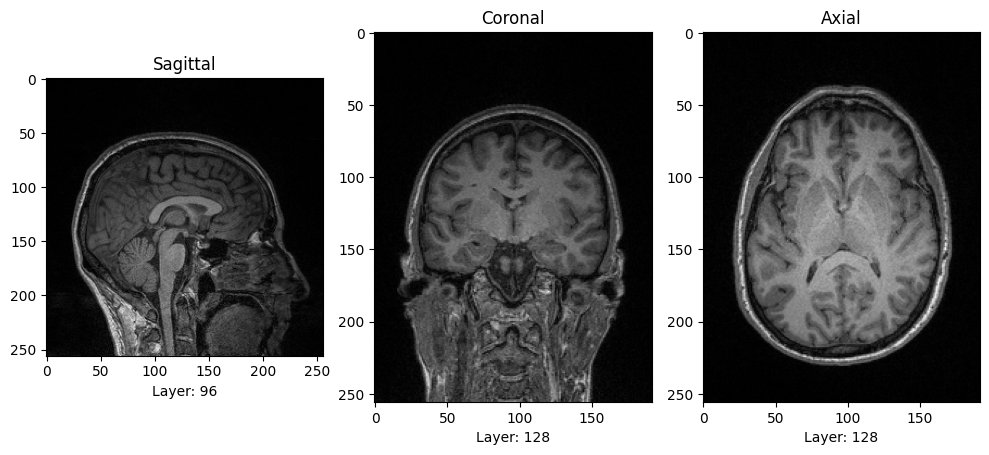

T2w
torch.Size([241, 241, 142]) 
 [[   1.            0.            0.         -117.54330444]
 [   0.            1.            0.          -98.55101013]
 [   0.            0.            1.          -72.65829468]
 [   0.            0.            0.            1.        ]]


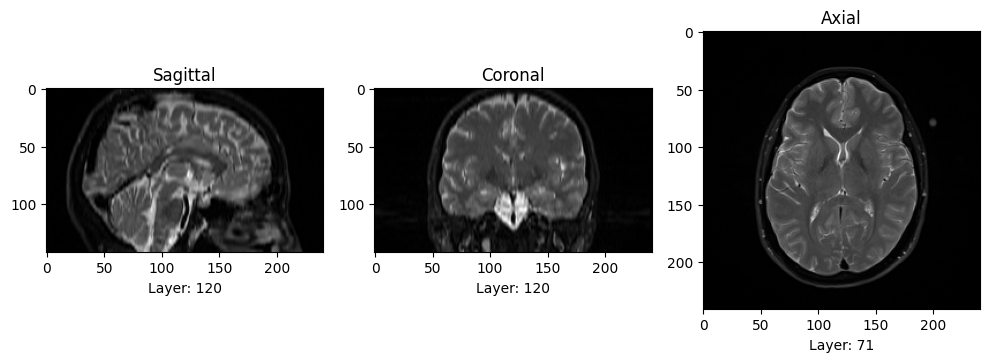

FLAIR
torch.Size([241, 241, 142]) 
 [[   1.            0.            0.         -107.7668609 ]
 [   0.            1.            0.          -87.31561279]
 [   0.            0.            1.          -75.46463776]
 [   0.            0.            0.            1.        ]]


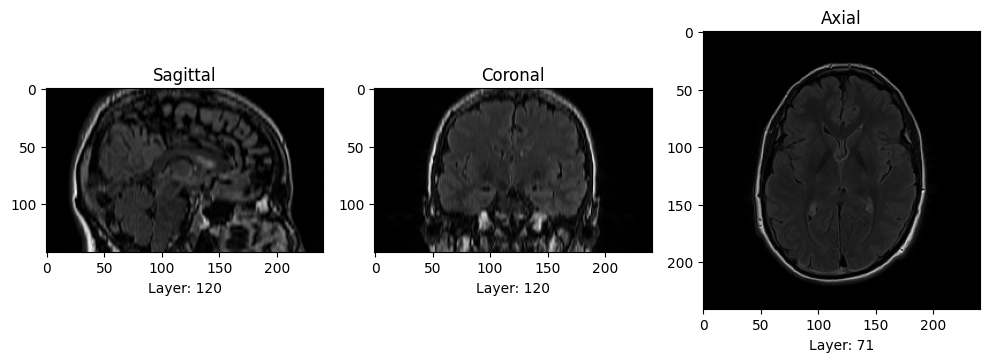

PD
torch.Size([241, 241, 142]) 
 [[   1.            0.            0.         -117.3739776 ]
 [   0.            1.            0.         -105.7731781 ]
 [   0.            0.            1.          -48.92372131]
 [   0.            0.            0.            1.        ]]


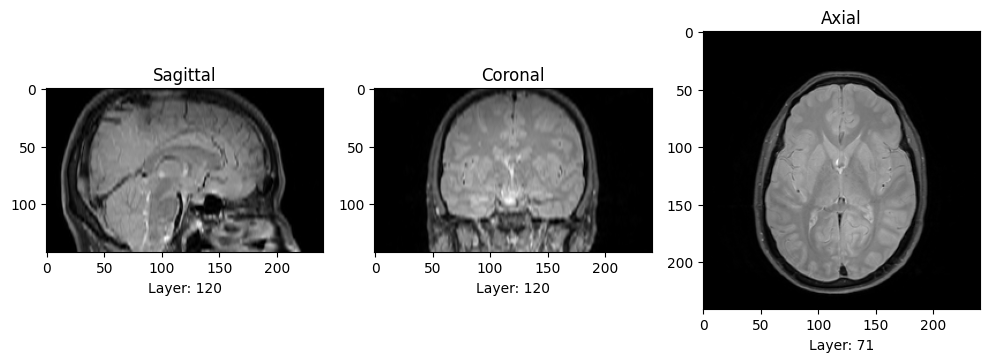

In [8]:

    
    

# for mod in modalities:
#     print(mod)
#     image_nib = test_sets[mod][30]['image']
#     image_vol, affine = nib_to_tensor(image_nib, resample='continuous')
#     shape = image_vol.shape[2:]
#     print(shape, '\n', affine)
#     show_slices(
#         image_vol[0, 0, ...],
#         (shape[0]//2, shape[1]//2, shape[2]//2),
#         'gray'
#     )